In [ ]:
#@title Librerias usadas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
#@title Montando Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Importando dataset
Suicide = pd.read_csv('/content/drive/MyDrive/IA I Proyecto final/Suicide_Detection.csv')
Suicide.head(5)

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [ ]:
#@title Eliminando columna Unnamed y agregando la longitud de las frases como característica
Suicide = Suicide.drop('Unnamed: 0', axis=1);
Suicide['Length'] = Suicide['text'].apply(lambda x: len(x.split(' ')))
Suicide.head(10)

,text,class,Length
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,143
1,Am I weird I don't get affected by compliments...,non-suicide,27
2,Finally 2020 is almost over... So I can never ...,non-suicide,26
3,i need helpjust help me im crying so hard,suicide,9
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,436
5,Honetly idkI dont know what im even doing here...,suicide,289
6,[Trigger warning] Excuse for self inflicted bu...,suicide,242
7,It ends tonight.I can’t do it anymore. \nI quit.,suicide,9
8,"Everyone wants to be ""edgy"" and it's making me...",non-suicide,188
9,My life is over at 20 years oldHello all. I am...,suicide,224


In [ ]:
#@title Cuantiles de las longitudes de las frases
for i in np.linspace(0,1,11):
    print(Suicide['Length'].quantile(i))

1.0
15.0
22.0
30.0
42.0
60.0
86.0
126.0
190.0
317.0
15632.0


In [ ]:
#@title Removiendo el 10% de las frases más largas
Suicide = Suicide[Suicide.Length <= 317]
len(Suicide)

208955

In [ ]:
#@title Función de preprocesamiento
def preprocesing(phrase):
  Words = list();
  for word in phrase.split(' '):
    word = word.replace('.', '')
    word = word.replace(',', '')
    if not word.strip():
      continue
    Words.append(word.upper())
  return Words

In [ ]:
#@title Separando en una lista todas las palabras de las frases
Words = list()
for phrase in Suicide['text']:
  Words += (preprocesing(phrase))
len(Words)

16595990

In [ ]:
#@title Agrupando palabras por frecuencias
Words_Freq = Counter(Words)
Words_Freq = pd.DataFrame({'Word':list(Words_Freq.keys()), 'Frequency':list(Words_Freq.values())})
print(len(Words_Freq))
Words_Freq.head(5)

352424


,Word,Frequency
0,EX,2394
1,WIFE,1825
2,THREATENING,294
3,SUICIDERECENTLY,1
4,I,891840


In [ ]:
#@title Cuantiles desde el 0.89 hasta el 1 de la frecuencia de las palabras
for i in [0.89,0.99,0.991,0.992,0.993,0.994,0.995,0.996,0.997,0.998,0.999, 1]:
    print(Words_Freq['Frequency'].quantile(i))

5.0
210.0
248.0
297.0
362.0
462.0
607.0
858.0
1316.4619999999413
2300.6159999999218
5504.657000001986
891840.0


In [ ]:
#@title Eliminando las palabras más repetidas y las menos repetidas
Words_Freq = Words_Freq[Words_Freq['Frequency']>Words_Freq['Frequency'].quantile(0.99)]
Words_Freq = Words_Freq[Words_Freq['Frequency']<31905]
print(len(Words_Freq))
Words_Freq

3443


,Word,Frequency
0,EX,2394
1,WIFE,1825
2,THREATENING,294
5,LEFT,9869
8,GOOD,25971
...,...,...
29991,PAINS,222
32589,ACHIEVED,222
41025,GRADUATION,231
46316,OWO,288


In [ ]:
#@title Cuantiles de 0.89 a 1 de la frecuencia (De nuevo)
for i in [0.89,0.99,0.991,0.992,0.993,0.994,0.995,0.996,0.997,0.998,0.999, 1]:
    print(Words_Freq['Frequency'].quantile(i))

3884.2800000000007
22196.39999999998
22859.037999999986
23751.51199999996
24444.72999999999
25285.376000000066
25867.04999999998
27043.111999999997
28597.72799999998
29736.495999999996
30552.850000000257
31777.0


In [ ]:
#@title Eliminando palabras menos usadas
Words_Freq = Words_Freq[Words_Freq['Frequency'] >= Words_Freq['Frequency'].quantile(0.89)]
print(len(Words_Freq))
Words_Freq.tail()

379


,Word,Frequency
2864,ALREADY,9088
3002,BORED,4164
3064,BED,4932
3393,FILLER,31215
9531,ㅤ,8301


In [ ]:
#@title Separación de todo el dataset en las palabras finales
# Final_Words = list(Words_Freq.Word)
# for word in Final_Words:
#   Suicide[word] = Suicide['text'].apply(lambda x: 1 if word in preprocesing(x) else 0)
# Suicide.drop('text', axis=1, inplace=True)
# Suicide['class'] = Suicide['class'].apply(lambda x: 1 if x == 'suicide' else 0)
# Suicide.to_csv('/content/drive/MyDrive/IA I Proyecto final/suicide_Detection_Proc.csv')
# Suicide.head()

In [ ]:
#@title Obteniendo dataset preprocesado
Suicide = pd.read_csv('/content/drive/MyDrive/IA I Proyecto final/suicide_Detection_Proc.csv')
Suicide = Suicide.drop('Unnamed: 0', axis=1);
Suicide.head(5)

,class,Length,LEFT,GOOD,HAS,MUCH,DECIDED,BACK,FEW,DAYS,...,FAR,TELLING,PHONE,MOTHER,BOYFRIEND,ALREADY,BORED,BED,FILLER,ㅤ
0,1,143,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,27,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,26,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,289,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


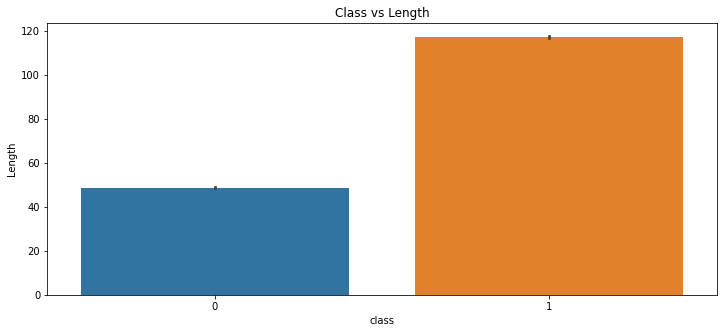

In [ ]:
#@title Gráfica de clase vs longitud de las frases
plt.figure(figsize=(12,5))
sns.barplot(x='class',y='Length',data=Suicide)
plt.title('Class vs Length')
plt.show()

In [ ]:
#@title Correlación de las características con la clase
Suicide.corr()['class'].sort_values(ascending=False)

class      1.000000
Length     0.458362
SUICIDE    0.299618
DIE        0.291281
END        0.273359
             ...   
TALKING    0.028184
POSTING    0.025266
DOES       0.019079
WEIRD     -0.029138
YOUR      -0.070855
Name: class, Length: 106, dtype: float64

In [ ]:
#@title Separación de datos de entrenamiento y de test
X = Suicide.values[:,1:]
y = Suicide.values[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=21)
y_train=y_train.astype('float64')
y_test=y_test.astype('float64')
y=y.astype('float64')

# GaussianNB

In [ ]:
GNB = GaussianNB()
GNB.fit(X_train, y_train)
print("%.3f"%accuracy_score(GNB.predict(X_test), y_test))

0.818


TPR: tasa de verdaderos positivos (sensibilidad)

TNR: tasa negativa verdadera (especificidad)

- Verdadero positivo = identificado correctamente
- Falso positivo = incorrectamente identificado
- Verdadero negativo = correctamente rechazado
- Falso negativo = incorrectamente rechazado



In [ ]:
def tpr(est,X,y):
    p = est.predict(X)
    return np.mean (p[y==1] == y[y==1])

def tnr(est,X,y):
    p = est.predict(X)
    return np.mean(p[y==0] == y[y==0])

Reporte

In [ ]:
y_pred = GNB.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83     11245
         1.0       0.81      0.79      0.80      9651

    accuracy                           0.82     20896
   macro avg       0.82      0.82      0.82     20896
weighted avg       0.82      0.82      0.82     20896



# Decision Tree classifier

In [ ]:
DT = DecisionTreeClassifier(max_depth=2)
DT.fit(X_train,y_train)
print(accuracy_score(DT.predict(X_test), y_test))

0.74645865237366


In [ ]:
DT = DecisionTreeClassifier(max_depth=100)
DT.fit(X_train,y_train)
print(accuracy_score(DT.predict(X_test), y_test))

0.8185298621745789


In [ ]:
DT = DecisionTreeClassifier(max_depth=10)
DT.fit(X_train,y_train)
print(accuracy_score(DT.predict(X_test), y_test))

0.8259954058192955


TPR: tasa de verdaderos positivos (sensibilidad)

TNR: tasa negativa verdadera (especificidad)

- Verdadero positivo = identificado correctamente
- Falso positivo = incorrectamente identificado
- Verdadero negativo = correctamente rechazado
- Falso negativo = incorrectamente rechazado

In [ ]:
def tpr(est,X,y):
    p = est.predict(X)
    return np.mean (p[y==1] == y[y==1])

def tnr(est,X,y):
    p = est.predict(X)
    return np.mean(p[y==0] == y[y==0])

Reporte

In [ ]:
y_pred = DT.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85     11245
         1.0       0.90      0.70      0.79      9651

    accuracy                           0.83     20896
   macro avg       0.84      0.82      0.82     20896
weighted avg       0.84      0.83      0.82     20896



# Random Forest classifier (RFC)

In [ ]:
RF = RandomForestClassifier()
RF.fit(X_train,y_train)
print(accuracy_score(RF.predict(X_test), y_test))

0.8797856049004594


Reporte

In [ ]:
y_pred = RF.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89     11245
         1.0       0.88      0.86      0.87      9651

    accuracy                           0.88     20896
   macro avg       0.88      0.88      0.88     20896
weighted avg       0.88      0.88      0.88     20896



# Support Vector Machine (SVM)

In [ ]:
SV = SVC()
SV.fit(X_train,y_train)
print(accuracy_score(SV.predict(X_test), y_test))

In [ ]:
def tpr(est,X,y):
    p = est.predict(X)
    return np.mean (p[y==1] == y[y==1])

def tnr(est,X,y):
    p = est.predict(X)
    return np.mean(p[y==0] == y[y==0])

Reporte

In [ ]:
y_pred = SV.predict(X_test)
print(classification_report(y_test, y_pred))

# Overfitting and Underfitting

In [ ]:
def plot_2Ddata_with_boundary(predict,X,y, alpha=.5):
    if predict is not None:
      n = 200
      mins,maxs = np.min(X,axis=0), np.max(X,axis=0)
      mins -= np.abs(mins)*.2
      maxs += np.abs(maxs)*.2
      d0 = np.linspace(mins[0], maxs[0],n)
      d1 = np.linspace(mins[1], maxs[1],n)
      gd0,gd1 = np.meshgrid(d0,d1)
      D = np.hstack((gd0.reshape(-1,1), gd1.reshape(-1,1)))
      p = (predict(D)*1.).reshape((n,n))
      plt.contourf(gd0,gd1,p, levels=[-0.1,0.5], alpha=0.5, cmap=plt.cm.Greys)
    plt.scatter(X[y==0][:,0], X[y==0][:,1], c="blue", alpha=alpha)
    plt.scatter(X[y==1][:,0], X[y==1][:,1], c="red", alpha=alpha)

In [ ]:
def plot_train_test(estimator, Xtr, Xts, ytr, yts, alpha=.5):
    estimator.fit(Xtr,ytr)
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plot_2Ddata_with_boundary(estimator.predict, Xtr,ytr, alpha=alpha)
    plt.title("TRAIN accuracy %.3f"%estimator.score(Xtr, ytr))
    plt.subplot(122)
    plot_2Ddata_with_boundary(estimator.predict, Xts,yts, alpha=alpha)
    plt.title("TEST accuracy %.3f"%estimator.score(Xts, yts))

In [ ]:
X = Suicide[['SUICIDE', 'Length']]
X = X.values[:,:]
y = Suicide.values[:,0]

Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=.5)

Xtr=Xtr.astype('float64')
Xts=Xts.astype('float64')
ytr=ytr.astype('float64')
yts=yts.astype('float64')
y=y.astype('float64')

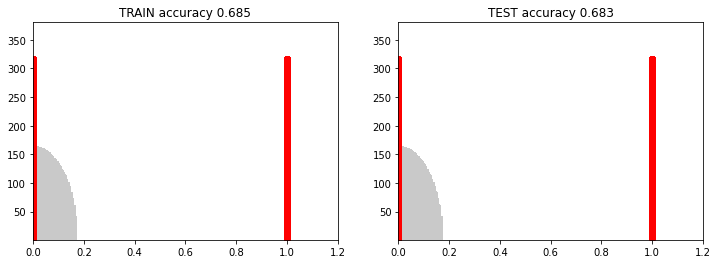

In [ ]:
plot_train_test(GaussianNB(), Xtr, Xts, ytr, yts)

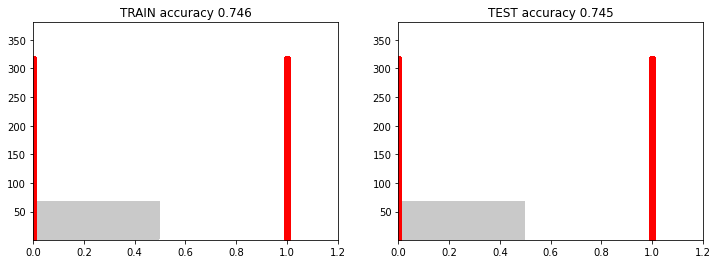

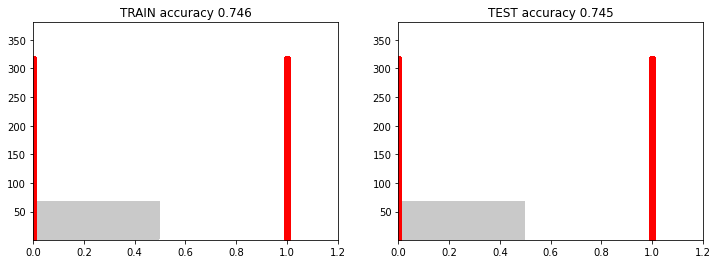

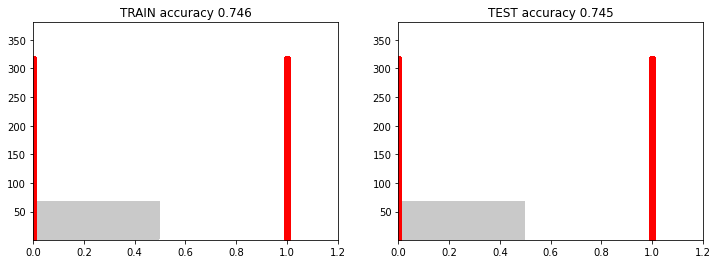

In [ ]:
plot_train_test(DecisionTreeClassifier(max_depth=5), Xtr, Xts, ytr, yts)
plot_train_test(DecisionTreeClassifier(max_depth=50), Xtr, Xts, ytr, yts)
plot_train_test(DecisionTreeClassifier(max_depth=500), Xtr, Xts, ytr, yts)

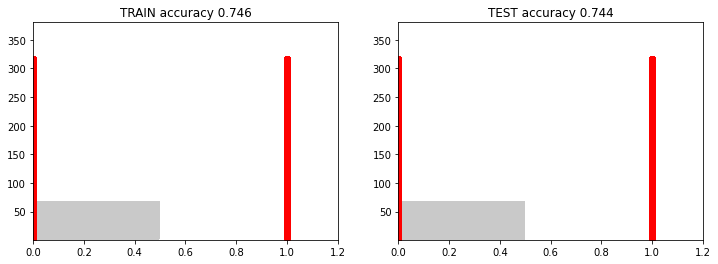

In [ ]:
plot_train_test(RandomForestClassifier(), Xtr, Xts, ytr, yts)

# Overfitting and Underfitting (No Graph)

In [ ]:
print("%.3f"%accuracy_score(GNB.predict(X_train), y_train))
print("%.3f"%accuracy_score(GNB.predict(X_test), y_test))

0.817
0.818


In [ ]:
print("%.3f"%accuracy_score(DT.predict(X_train), y_train))
print("%.3f"%accuracy_score(DT.predict(X_test), y_test))

0.833
0.826


In [ ]:
print("%.3f"%accuracy_score(RF.predict(X_train), y_train))
print("%.3f"%accuracy_score(RF.predict(X_test), y_test))

0.996
0.880


# Length Only


In [ ]:
#@title Separación de datos de entrenamiento y de test
X = Suicide.values[:,1]
X = X.reshape(-1,1)
y = Suicide.values[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=21)
y_train=y_train.astype('float64')
y_test=y_test.astype('float64')
y=y.astype('float64')

# GaussianNB

In [ ]:
GNB = GaussianNB()
GNB.fit(X_train, y_train)
print("%.3f"%accuracy_score(GNB.predict(X_test), y_test))

0.697


In [ ]:
y_pred = GNB.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.66      0.89      0.76     11245
         1.0       0.79      0.47      0.59      9651

    accuracy                           0.70     20896
   macro avg       0.73      0.68      0.68     20896
weighted avg       0.72      0.70      0.68     20896



# Decision Tree

In [ ]:
DT = DecisionTreeClassifier(max_depth=10)
DT.fit(X_train,y_train)
print(accuracy_score(DT.predict(X_test), y_test))

0.7315275650842267


In [ ]:
y_pred = DT.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.77      0.75     11245
         1.0       0.72      0.69      0.70      9651

    accuracy                           0.73     20896
   macro avg       0.73      0.73      0.73     20896
weighted avg       0.73      0.73      0.73     20896



# Random Forest

In [ ]:
RF = RandomForestClassifier()
RF.fit(X_train,y_train)
print(accuracy_score(RF.predict(X_test), y_test))

0.7312404287901991


In [ ]:
y_pred = RF.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.77      0.76     11245
         1.0       0.72      0.69      0.70      9651

    accuracy                           0.73     20896
   macro avg       0.73      0.73      0.73     20896
weighted avg       0.73      0.73      0.73     20896



# Overfitting and Underfitting

In [ ]:
print("%.3f"%accuracy_score(GNB.predict(X_train), y_train))
print("%.3f"%accuracy_score(GNB.predict(X_test), y_test))

0.700
0.697


In [ ]:
print("%.3f"%accuracy_score(DT.predict(X_train), y_train))
print("%.3f"%accuracy_score(DT.predict(X_test), y_test))

0.734
0.732


In [ ]:
print("%.3f"%accuracy_score(RF.predict(X_train), y_train))
print("%.3f"%accuracy_score(RF.predict(X_test), y_test))

0.734
0.731


# Words Only

In [ ]:
#@title Separación de datos de entrenamiento y de test
X = Suicide.values[:,2:]
y = Suicide.values[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=21)
y_train=y_train.astype('float64')
y_test=y_test.astype('float64')
y=y.astype('float64')

# Gaussian NB

In [ ]:
GNB = GaussianNB()
GNB.fit(X_train, y_train)
print("%.3f"%accuracy_score(GNB.predict(X_test), y_test))

0.816


In [ ]:
y_pred = GNB.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.84      0.83     11245
         1.0       0.81      0.79      0.80      9651

    accuracy                           0.82     20896
   macro avg       0.82      0.81      0.82     20896
weighted avg       0.82      0.82      0.82     20896



# Decision Tree

In [ ]:
DT = DecisionTreeClassifier(max_depth=10)
DT.fit(X_train,y_train)
print(accuracy_score(DT.predict(X_test), y_test))

0.8236504594180705


In [ ]:
y_pred = DT.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.89      0.85     11245
         1.0       0.86      0.74      0.80      9651

    accuracy                           0.82     20896
   macro avg       0.83      0.82      0.82     20896
weighted avg       0.83      0.82      0.82     20896



# Random Forest

In [ ]:
RF = RandomForestClassifier()
RF.fit(X_train,y_train)
print(accuracy_score(RF.predict(X_test), y_test))

0.8801205972434916


In [ ]:
y_pred = RF.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     11245
         1.0       0.87      0.87      0.87      9651

    accuracy                           0.88     20896
   macro avg       0.88      0.88      0.88     20896
weighted avg       0.88      0.88      0.88     20896



# Overfitting and Underfitting

In [ ]:
print("%.3f"%accuracy_score(GNB.predict(X_train), y_train))
print("%.3f"%accuracy_score(GNB.predict(X_test), y_test))

0.817
0.816


In [ ]:
print("%.3f"%accuracy_score(DT.predict(X_train), y_train))
print("%.3f"%accuracy_score(DT.predict(X_test), y_test))

0.831
0.824


In [ ]:
print("%.3f"%accuracy_score(RF.predict(X_train), y_train))
print("%.3f"%accuracy_score(RF.predict(X_test), y_test))

0.992
0.880
